# Models Evaluation

The dataset has been created from a mixture of sources:
- my personal email archives
- the [spamassassin corpus](https://spamassassin.apache.org/old/publiccorpus/) (it's really old)
- the [SPAM archive](http://untroubled.org/spam/) by untroubled

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# import the dataset
dataset = pd.read_csv("data/spam.csv")

Here we have many features that have been extracted with `spamanalyzer` library: there are headers and body analysis. The expected label is the column `is_spam`

In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19901 entries, 0 to 19900
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   has_spf                         19901 non-null  bool   
 1   has_dkim                        19901 non-null  bool   
 2   has_dmarc                       19901 non-null  bool   
 3   domain_matches                  19901 non-null  bool   
 4   auth_warn                       19901 non-null  bool   
 5   has_suspect_subject             19901 non-null  bool   
 6   subject_is_uppercase            19901 non-null  bool   
 7   send_date_is_RFC2822_compliant  19901 non-null  bool   
 8   send_date_tz_is_valid           19901 non-null  bool   
 9   has_received_date               19901 non-null  bool   
 10  uppercase_body                  19901 non-null  bool   
 11  script                          19901 non-null  bool   
 12  images                          

## Data visualization

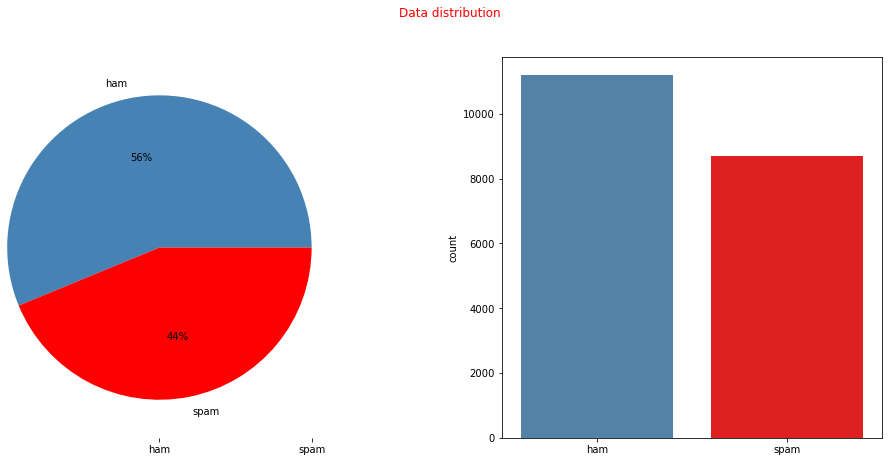

In [21]:
import seaborn as sns

ham  = dataset[dataset["is_spam"] == 0]
spam = dataset[dataset["is_spam"] == 1]

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,7))
fig.suptitle('Data distribution', c='r')

data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['ham', 'spam']
colors = ['steelblue', 'red']

axes[0].pie(data, labels = labels, autopct='%.0f%%', colors=colors)

sns.countplot(x = ['ham']*len(ham) + ['spam']*len(spam), palette=colors, ax=axes[1]);

PCA makes possible to reduce the dimensions of the dataset, this way is possible to plot data in a 2d plot

In [5]:
# split the dataset in features and labels
X = dataset.drop("is_spam", axis=1)
y = dataset["is_spam"]

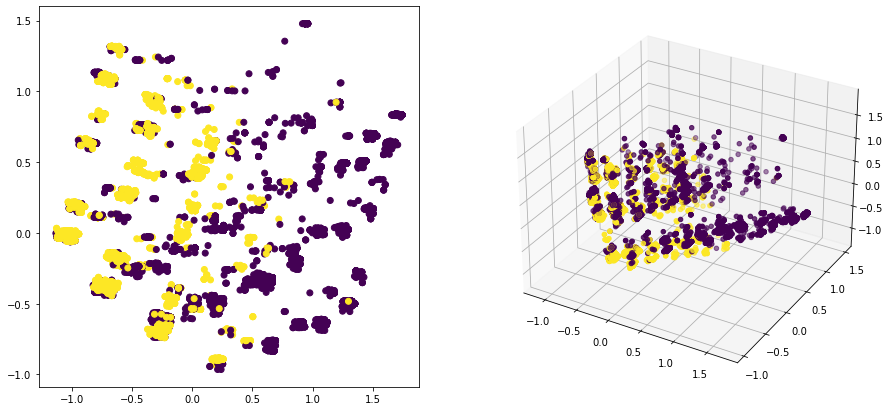

In [28]:
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA

fig = plt.figure(figsize=(15, 7))
colors = ['steelblue', 'red']

# 2d plot
ax = fig.add_subplot(1, 2, 1)
X_2 = PCA(n_components=2).fit_transform(X)
emails = pd.DataFrame(X_2)
ax.scatter(emails[0], emails[1], c=y)

# 3d plot
ax = fig.add_subplot(1, 2, 2, projection='3d')
X_3 = PCA(n_components=3).fit_transform(X)
emails = pd.DataFrame(X_3)

ax.scatter(emails[0], emails[1], emails[2], c=y);

We see some overlap between the two classes, but it's possible to see that the spam emails are more concentrated in the lower left corner

In [8]:
from sklearn.model_selection import train_test_split
# split in train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

## Decision Tree

In [8]:
%%time
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tc = DecisionTreeClassifier()

params = {
    'min_samples_split': [2, 5, 10, 20, 30, 50, 60],
    'min_samples_leaf': [1, 2, 5, 10, 20, 30, 40, 50, 60],
    'max_leaf_nodes': [x for x in range(2, 121, 2)]
}

gscv = GridSearchCV(
    estimator=tc,
    return_train_score=True,
    param_grid=params,
    verbose=1,
    n_jobs=-1
)

gscv.fit(X_train, y_train)

gscv.best_params_

Fitting 5 folds for each of 3780 candidates, totalling 18900 fits
CPU times: user 4.61 s, sys: 646 ms, total: 5.25 s
Wall time: 1min 4s


{'max_leaf_nodes': 120, 'min_samples_leaf': 1, 'min_samples_split': 20}

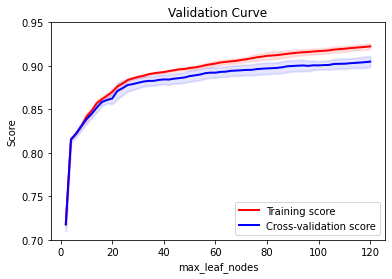

In [12]:
import numpy as np

plot_grid_search_validation_curve(gscv, "max_leaf_nodes", ylim=[0.7, 0.95])

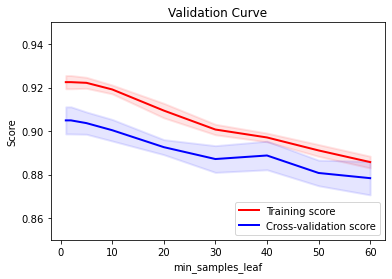

In [13]:
plot_grid_search_validation_curve(gscv, "min_samples_leaf", ylim=[0.85, 0.95])

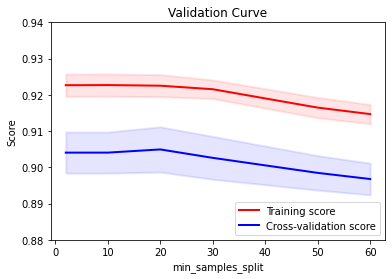

In [14]:
plot_grid_search_validation_curve(gscv, "min_samples_split", ylim=[0.88, 0.94])

In [15]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(
    max_leaf_nodes=120,
    min_samples_leaf=1,
    min_samples_split=20,
    random_state=42,
    splitter='best'
)

tree.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=120, min_samples_split=20,
                       random_state=42)

In [16]:
tree.feature_importances_

array([0.4016611 , 0.01811475, 0.        , 0.00676701, 0.00182249,
       0.00172735, 0.03214049, 0.00293565, 0.01252585, 0.00789527,
       0.00129854, 0.0009133 , 0.24933753, 0.00520886, 0.01514014,
       0.00183443, 0.03398189, 0.02640206, 0.00264756, 0.08749609,
       0.05883771, 0.03131193, 0.        ])

In [17]:
y_pred = tree.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9065561416729465

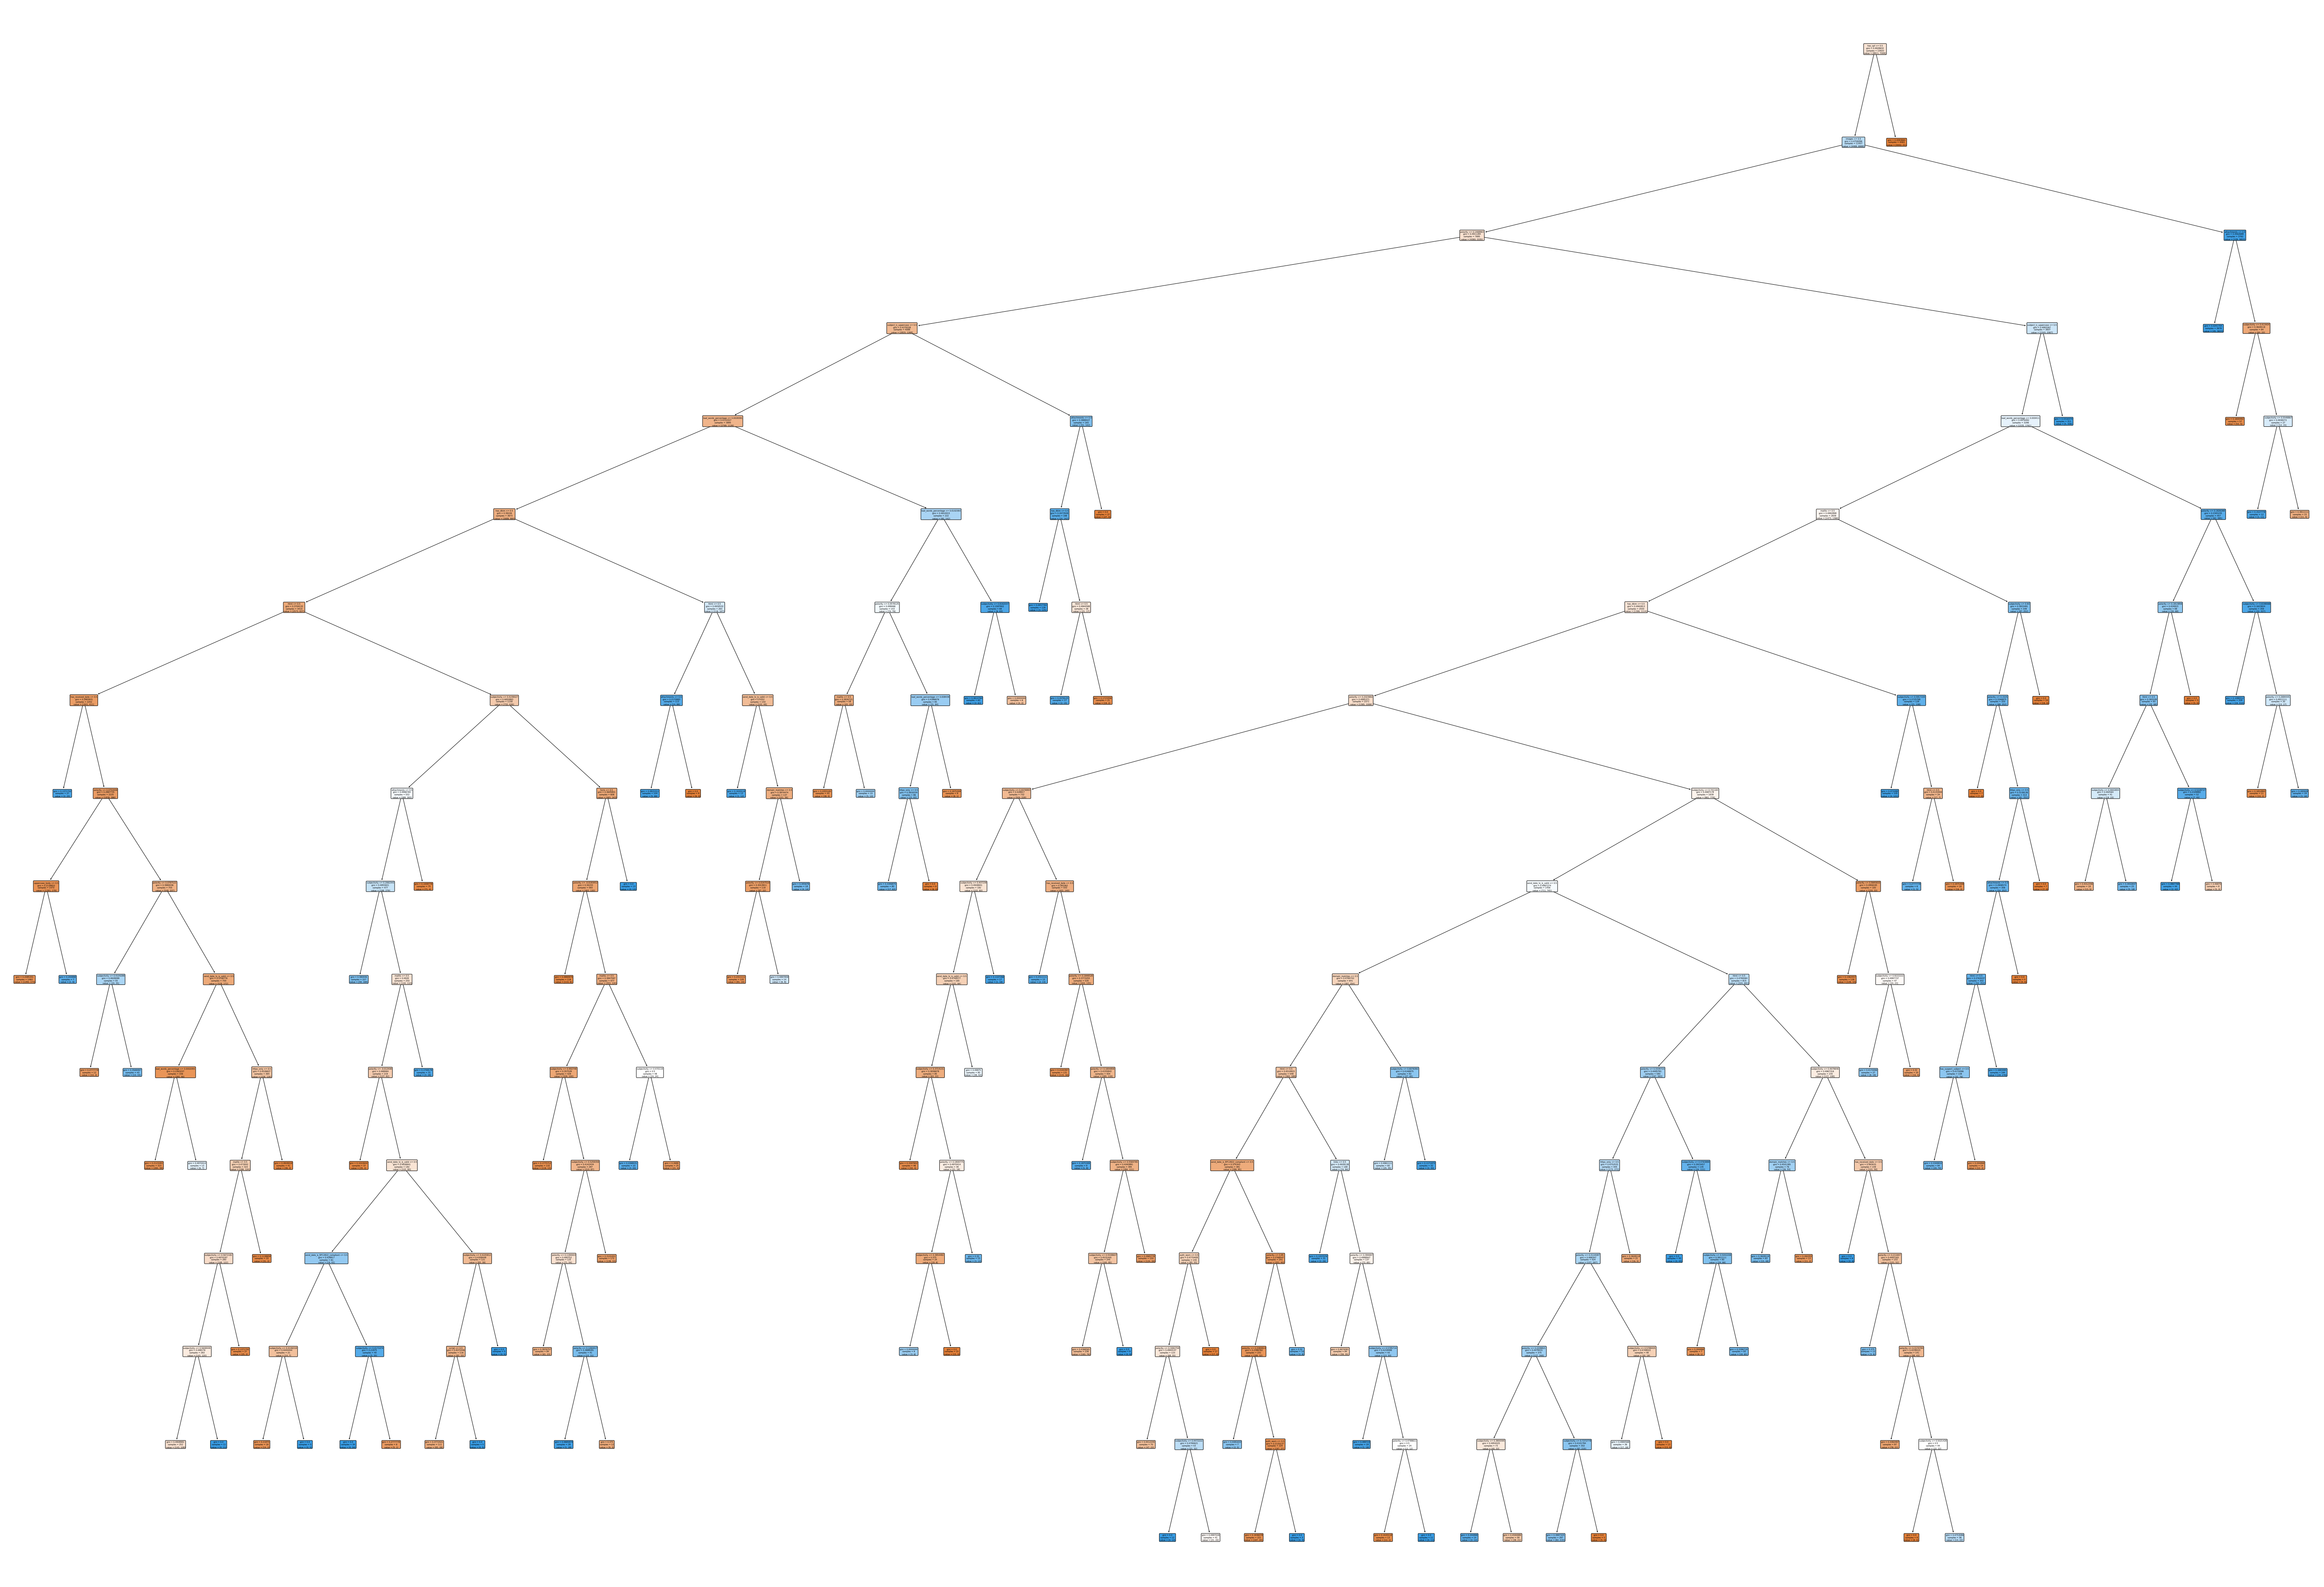

In [19]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(100,70))
plot_tree(tree, ax=ax,
          precision=7,
          feature_names=X_train.columns.to_list(),
          filled=True, rounded=True);

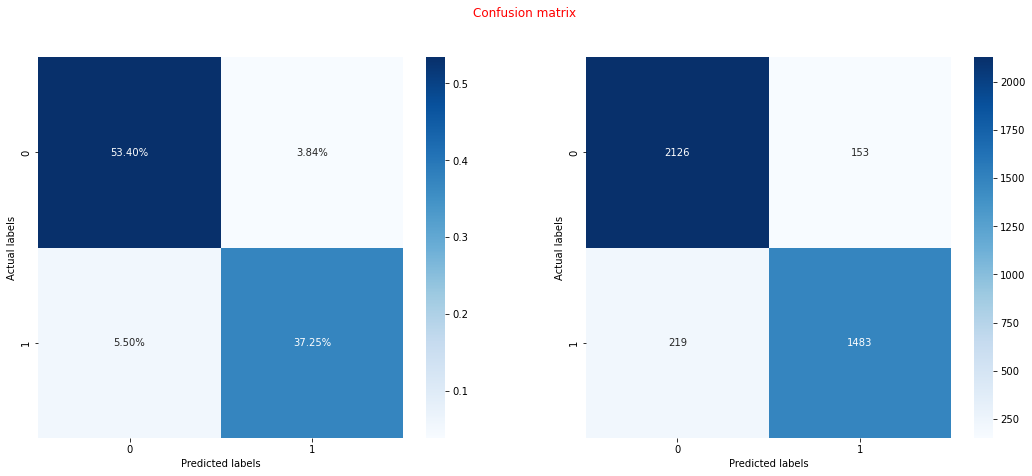

In [20]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

conf_mx = confusion_matrix(y_test, tree.predict(X_test))

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')
sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels');

## Random Forest

In [52]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

randf = RandomForestClassifier()

params = {
    'n_estimators': [x for x in range(20, 401, 20)],
    'max_features': ['log2', 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

gscv = GridSearchCV(estimator = randf, 
                         return_train_score=True,
                         param_grid=params,
                         cv = 5,
                         verbose=1,
                         n_jobs = -1)

gscv.fit(X_train, y_train)

gscv.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits
CPU times: user 5.31 s, sys: 635 ms, total: 5.94 s
Wall time: 11min 11s


{'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 340}

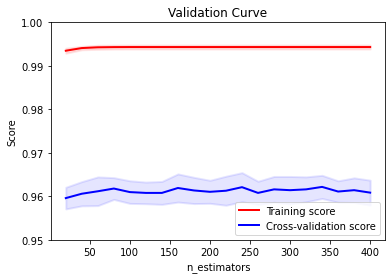

In [53]:
plot_grid_search_validation_curve(gscv, 'n_estimators', ylim=(0.95, 1))

In [54]:
rfc = RandomForestClassifier(
    max_features="log2",
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=340,
    random_state=42
)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

accuracy_score(y_test, y_pred)

0.9723687515699573

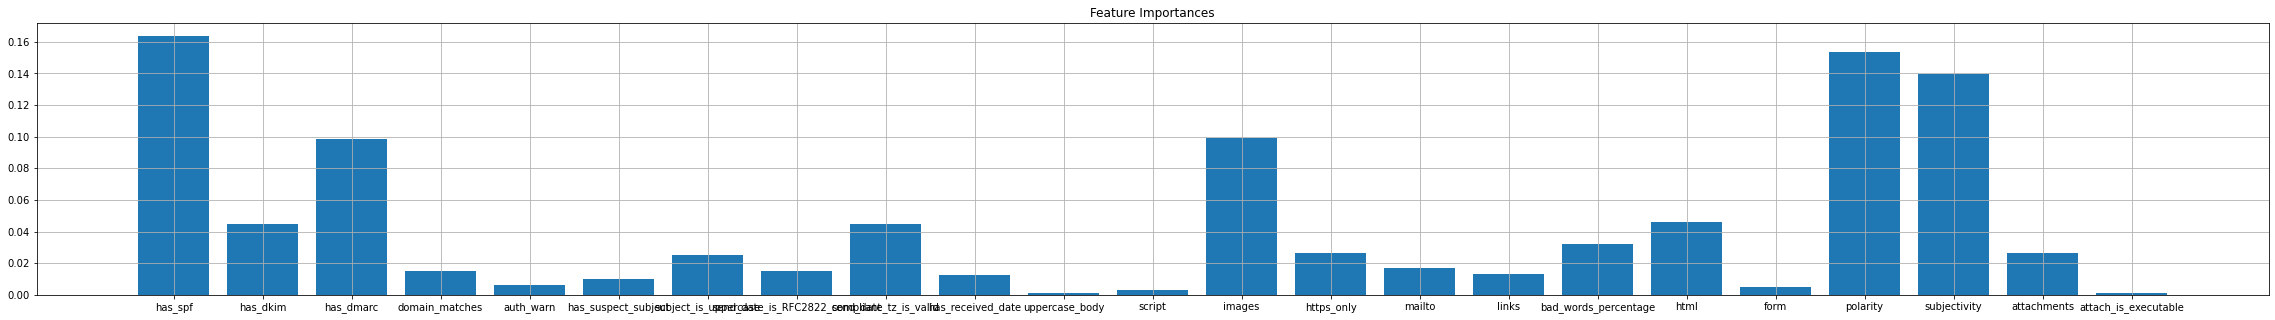

In [55]:
feature_names = X.columns.to_list()

fig, ax = plt.subplots(figsize=(40,5))
ax.bar(range(0, X.shape[1]), rfc.feature_importances_)
ax.set_title("Feature Importances")
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels(feature_names)
ax.grid()

In [56]:
features = np.array(feature_names)
features[rfc.feature_importances_.argsort()[::-1]]
print("Features sorted by their significativity score:")
for i, feature in enumerate(features[rfc.feature_importances_.argsort()[::-1]]):
    print(f"{i+1}: {feature}")

Features sorted by their significativity score:
1: has_spf
2: polarity
3: subjectivity
4: images
5: has_dmarc
6: html
7: send_date_tz_is_valid
8: has_dkim
9: bad_words_percentage
10: attachments
11: https_only
12: subject_is_uppercase
13: mailto
14: send_date_is_RFC2822_compliant
15: domain_matches
16: links
17: has_received_date
18: has_suspect_subject
19: auth_warn
20: form
21: script
22: uppercase_body
23: attach_is_executable


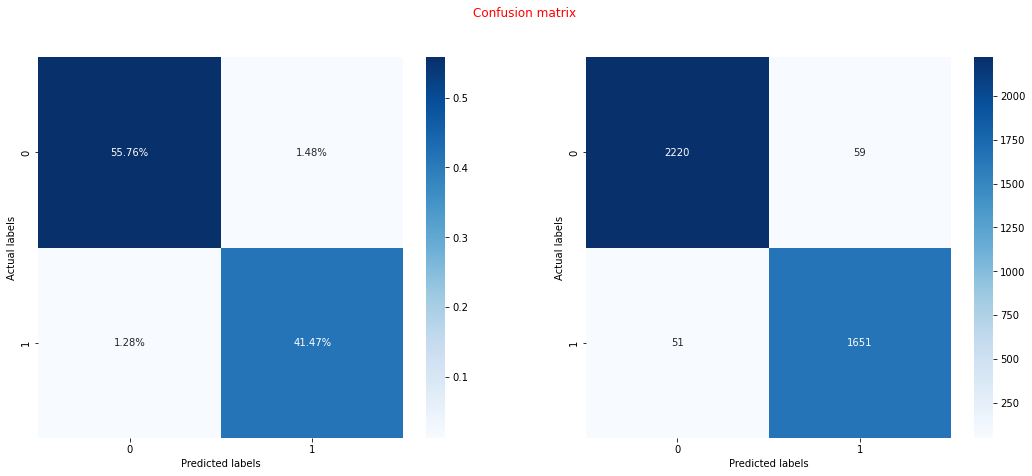

In [57]:
conf_mx = confusion_matrix(y_test, rfc.predict(X_test))

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')
sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels');

In [58]:
import pickle

# fit on entire dataset before saving
rfc.fit(X, y)
with open('/media/matteo/Dati/Progetti/spam-analyzer/conf/classifier.pkl', 'wb') as f:
    pickle.dump(rfc, f)

## KNN

In [33]:
from sklearn.neighbors import KNeighborsClassifier
maxim = 0
i = 1
for n in range(1, 101):
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)

    knn.fit(X_train, y_train)

    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    if acc > maxim:
        maxim = acc
        best = knn
        i = n
print(maxim, "at index", i)

0.9660889223813113 at index 1


In [36]:
y_pred = best.predict(X_test)
accuracy_score(y_test, y_pred)

0.9228836975634263

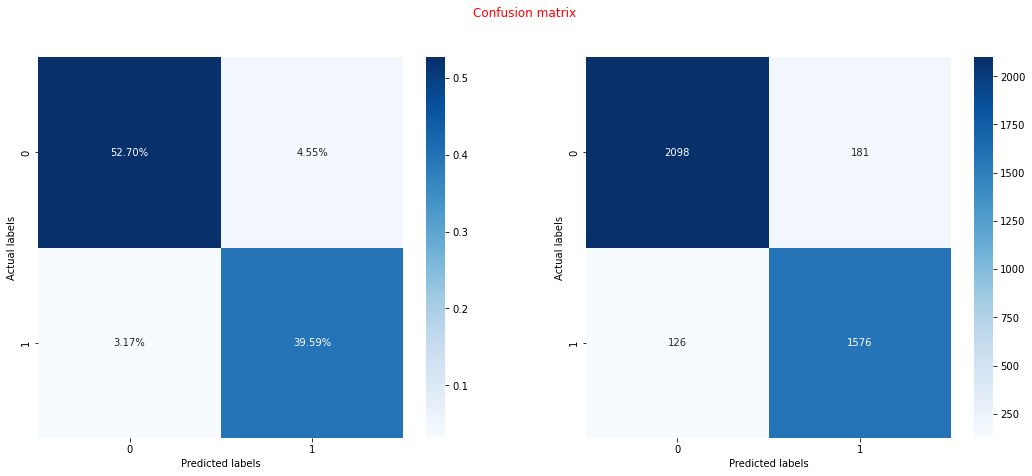

In [37]:
conf_mx = confusion_matrix(y_test, best.predict(X_test))

fig, axes = plt.subplots(1, 2, sharex=True, figsize=(18,7))
fig.suptitle('Confusion matrix', c='r')
sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels');

In [10]:
import numbers

def plot_grid_search_validation_curve(grid, param_to_vary,
                                      title='Validation Curve', ylim=None,
                                      xlim=None, log=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""

    df_cv_results = pd.DataFrame(grid.cv_results_)
    train_scores_mean = df_cv_results['mean_train_score']
    valid_scores_mean = df_cv_results['mean_test_score']
    train_scores_std = df_cv_results['std_train_score']
    valid_scores_std = df_cv_results['std_test_score']

    param_cols = [c for c in df_cv_results.columns if c[:6] == 'param_']
    param_ranges = [grid.param_grid[p[6:]] for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    train_scores_mean = np.array(train_scores_mean).reshape(*param_ranges_lengths)
    valid_scores_mean = np.array(valid_scores_mean).reshape(*param_ranges_lengths)
    train_scores_std = np.array(train_scores_std).reshape(*param_ranges_lengths)
    valid_scores_std = np.array(valid_scores_std).reshape(*param_ranges_lengths)

    param_to_vary_idx = param_cols.index('param_{}'.format(param_to_vary))

    slices = []
    for idx, param in enumerate(grid.best_params_):
        if (idx == param_to_vary_idx):
            slices.append(slice(None))
            continue
        best_param_val = grid.best_params_[param]
        idx_of_best_param = 0
        if isinstance(param_ranges[idx], np.ndarray):
            idx_of_best_param = param_ranges[idx].tolist().index(best_param_val)
        else:
            idx_of_best_param = param_ranges[idx].index(best_param_val)
        slices.append(idx_of_best_param)

    train_scores_mean = train_scores_mean[tuple(slices)]
    valid_scores_mean = valid_scores_mean[tuple(slices)]
    train_scores_std = train_scores_std[tuple(slices)]
    valid_scores_std = valid_scores_std[tuple(slices)]

    plt.clf()

    plt.title(title)
    plt.xlabel(param_to_vary)
    plt.ylabel('Score')

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    if log:
        plot_fn = plt.semilogx

    param_range = param_ranges[param_to_vary_idx]
    if (not isinstance(param_range[0], numbers.Number)):
        param_range = [str(x) for x in param_range]
    plot_fn(param_range, train_scores_mean, label='Training score', color='r',
            lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color='r', lw=lw)
    plot_fn(param_range, valid_scores_mean, label='Cross-validation score',
            color='b', lw=lw)
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color='b', lw=lw)

    plt.legend(loc='lower right')

    plt.show()